In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
import getpass

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf
%matplotlib inline

In [24]:
username = getpass.getuser()

In [91]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Mouse ID']=='Baby']
#data = data[data['Condition']=='90-10']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
0,0,Baby,04192018_Baby,11.0,11.0,6.0,8.0,1.0,0.0,0.0,...,0.432,1.262,0.522,1.0,0.0,1.0,1.0,90-10,1.0,59.0
1,1,Baby,04192018_Baby,12.0,12.0,7.0,9.0,2.0,0.0,0.0,...,0.522,2.181,0.531,1.0,0.0,1.0,1.0,90-10,1.0,59.0
2,2,Baby,04192018_Baby,13.0,13.0,8.0,10.0,3.0,1.0,1.0,...,0.531,1.737,0.540,1.0,0.0,1.0,1.0,90-10,1.0,59.0
3,3,Baby,04192018_Baby,14.0,14.0,9.0,11.0,4.0,1.0,0.0,...,0.540,1.791,0.248,1.0,0.0,1.0,1.0,90-10,1.0,59.0
4,4,Baby,04192018_Baby,15.0,15.0,10.0,12.0,5.0,1.0,1.0,...,0.248,1.275,0.360,1.0,0.0,1.0,1.0,90-10,1.0,59.0


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [46]:
#include past 10 choice and reward values (this is most convenient given the current data structure)
choice_history = []
reward_history = []
for col in data.columns:
    if '_Port' in col:
        choice_history.append(data[col][:])
    elif '_Reward' in col:
        reward_history.append(data[col][:])
        
choice_history = np.transpose(np.asarray(choice_history))
reward_history = np.transpose(np.asarray(reward_history))
switch_history = np.abs(np.diff(choice_history)) # right now just missing whether or not switched on n-10 trial

#current trial decision and outcome 
choice = []
reward = []
switch = []

for col in data.columns:
    if 'Decision' in col:
        #print(col)
        choice.append(data[col][:])
    elif 'Reward' in col:
        #print(col)
        reward.append(data[col][:])
    elif 'Switch' in col:
        switch.append(data[col][:])

choice = np.transpose(np.asarray(choice))
reward = np.transpose(np.asarray(reward))
switch = np.transpose(np.asarray(switch))

### set up which datasets will be predictor and target

In [47]:
# set up as X and Y for logistic regression (X contains all predictors)
X_choice = np.column_stack((choice_history, reward_history)) # n-1 to n-10 trial choices and outcomes
X_switch = np.column_stack((switch_history, reward_history[:,0:9])) # n-1 to n-10 trial switches and outcomes
X_choice_switch = np.column_stack((switch_history, choice_history[:,0:9], reward_history[:,0:9]))

Y_choice = choice.ravel() # current trial choices
Y_switch = switch.ravel() # current trial switches

### split data into training and testing datasets
--right now 70% to train, 30% test

--X (train and test) mxn matrix with m trials and [n/2 choice, n/2 corresponding reward outcomes]
            
            X[:,0:9] = choice_history
            
            X[:,10:19] = reward_history

--Y (train and test) mx1 matrix with m trials and 1 choice outcome


In [48]:
#train on proportion of data up to the 'cutoff.' hold out the rest as test data.
idx = np.random.permutation(len(X_choice))
cutoff = 0.7
idx_train = idx[0:int(len(X_choice)*cutoff)]
idx_test = idx[int(len(X_choice)*cutoff):]

X_train = X_choice[idx_train]
X_test = X_choice[idx_test]

Y_train_choice = Y_choice[idx_train]
Y_test_choice = Y_choice[idx_test]

Y_train_switch = Y_switch[idx_train]
Y_test_switch = Y_switch[idx_test]

### Logistic regression
Compare training on port choice (lr_port) vs training on switch (lr_switch)

### lr1 - train on port choice to predict port choice
#### Evaluate performance on predicting choice and predicting switches

In [162]:
lr1_choice = LogisticRegression()
lr1_choice.fit(X_train, Y_train_choice)

lr1_choice_proba = lr1_choice.predict_proba(X_test)
lr1_choice_predict = lr1_choice.predict(X_test)

score_lr1_choice = lr1_choice.score(X_test, Y_test_choice)
metrics_lr1_choice = sklearn.metrics.precision_recall_fscore_support(Y_test_choice, lr1_choice_predict)

prev_choice = data['1_Port'][idx_test]
lr1_switch_predict = np.abs(lr1_choice_predict-prev_choice)
#switch_true = np.abs([Y_test_choice[n] - X_test[n,9] for n in range(len(Y_test_choice))]) # actual switches from test port (n) vs n-1 port (test[i,9]) -- matches Y_test_switch
#lr1_switch_predict = np.abs([lr1_choice_predict[n] - X_test[n,9] for n in range(len(lr1_choice_predict))])
metrics_lr1_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr1_switch_predict)

#acc_pos,acc_neg,F1=sf.score_both_and_confuse(lr1_switch_predict,Y_test_switch,confusion=False,disp=True)

In [160]:
lr1_switch_predict.sum()

6881.0

In [167]:
X_test[1:10,9]


array([ 1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.])

In [169]:
data['1_Port'][idx_test].sort()

/Users/celiaberon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  """Entry point for launching an IPython kernel.


In [157]:
lr1_switch_predict.sum()

2767.0

In [163]:
metrics_lr1_switch

(array([ 0.93396906,  0.26237803]),
 array([ 0.93026752,  0.27385892]),
 array([ 0.93211461,  0.26799557]),
 array([29269,  2651]))

### lr2 - train on switches to predict switches

In [53]:
# redefine training and testing sets to use switch history and current switch decision
X = np.column_stack((switch_history, reward_history[:,0:8]))
X_train = X[idx_train]
X_test = X[idx_test]


# train and test LR
lr2_switch = LogisticRegression()
lr2_switch.fit(X_train, Y_train_switch)

lr2_switch_proba = lr2_switch.predict_proba(X_test)
lr2_switch_predict = lr2_switch.predict(X_test)

score_lr2_switch = lr2_switch.score(X_test, Y_test_switch)
metrics_lr2_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr2_switch_predict)


(array([  2.50190000e+04,   3.55900000e+03,   1.33700000e+03,
          5.43000000e+02,   6.50000000e+02,   4.57000000e+02,
          2.23000000e+02,   8.70000000e+01,   3.50000000e+01,
          1.00000000e+01]),
 array([ 0.04073286,  0.09529789,  0.14986293,  0.20442797,  0.25899301,
         0.31355805,  0.36812309,  0.42268813,  0.47725317,  0.53181821,
         0.58638325]),
 <a list of 10 Patch objects>)

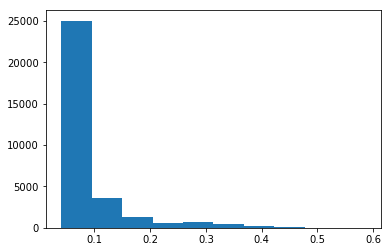

In [54]:
plt.hist(lr2_switch_proba[:,1])

### lr2.1 - change decision boundary

In [96]:
metrics_db = []
decision_boundaries = np.arange(0.05,0.6,0.05)
for boundary in decision_boundaries:
    temp_predict = lr2_switch_proba[:,1]>boundary
    metrics_temp = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, temp_predict)
    metrics_db.append(metrics_temp)

In [97]:
decision_boundaries

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55])

In [98]:
metrics_db

[(array([ 0.96931433,  0.12488729]),
  array([ 0.46947282,  0.83591098]),
  array([ 0.63256992,  0.21730816]),
  array([29269,  2651])),
 (array([ 0.95194688,  0.22074509]),
  array([ 0.82777   ,  0.53866465]),
  array([ 0.88552632,  0.31315789]),
  array([29269,  2651])),
 (array([ 0.93128302,  0.20575022]),
  array([ 0.90939219,  0.25914749]),
  array([ 0.92020743,  0.2293823 ]),
  array([29269,  2651])),
 (array([ 0.92497069,  0.19903148]),
  array([ 0.9434897 ,  0.15503584]),
  array([ 0.93413842,  0.17430025]),
  array([29269,  2651])),
 (array([ 0.9213705 ,  0.17046194]),
  array([ 0.95643855,  0.09883063]),
  array([ 0.93857708,  0.12511939]),
  array([29269,  2651])),
 (array([ 0.91971535,  0.1681592 ]),
  array([ 0.97143736,  0.06374953]),
  array([ 0.94486907,  0.09245077]),
  array([29269,  2651])),
 (array([ 0.91872556,  0.20169851]),
  array([ 0.98715364,  0.03583553]),
  array([ 0.95171119,  0.06085842]),
  array([29269,  2651])),
 (array([ 0.91771753,  0.205     ]),
  ar

In [112]:
y_predict = np.zeros_like(lr2_switch_proba)
y_predict[lr2_switch_proba > 0.2] = 1

score_switch_2 = 1-(np.sum([np.abs(y_predict[i,1] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))
switch_predict_2 = np.abs([y_predict[n,1] - X_test[n,8] for n in range(len(y_predict))])

metrics_switch_3 = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, switch_predict_2)


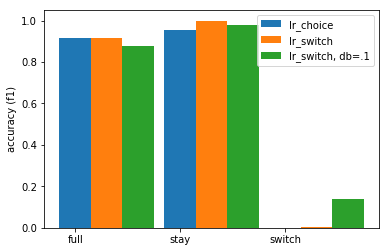

In [120]:
## height_a = [score_lr1_choice, metrics_lr1_switch[2][0], metrics_lr1_switch[2][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[1][0], metrics_lr2_switch[1][1]]
height_c = [score_switch_2, metrics_switch_3[1][0], metrics_switch_3[1][1]]

barWidth = 0.3
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr_choice')
plt.bar(r2, height_b, width=barWidth, label='lr_switch')
plt.bar(r3, height_c, width=barWidth, label='lr_switch, db=.1')
plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()

### restructure dataset to reflect action value instead of raw actions

In [57]:
# value = L when choice = 0 and reward = 1 or when choice = 1 and reward = 0 
# value = R when choice = 1 and reward = 1 or when choice = 0 and reward = 0
value_history = (choice_history==reward_history).astype('int') # gives action value with R=1, L=0

### lr3 - use action value to predict choice

In [58]:
# redefine training set to use value history
X = value_history
X_train = X[idx_train]
X_test = X[idx_test]

# train and test LR
lr3_value = LogisticRegression()
lr3_value.fit(X_train, Y_train_choice)

lr3_value_proba = lr3_value.predict_proba(X_test)
lr3_value_predict = lr3_value.predict(X_test)

score_lr3_value_choice = lr3_value.score(X_test, Y_test_choice)
metrics_lr3_value = sklearn.metrics.precision_recall_fscore_support(Y_test_choice, lr3_value_predict)

lr3_switch_predict = np.abs([lr3_value_predict[n] - X_test[n,8] for n in range(len(lr3_value_predict))])
metrics_lr3_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr3_switch_predict)

score_switch_2 = 1-(np.sum([np.abs(lr3_value_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))


### what about a logistic regression with more inputs?

In [61]:
#train on proportion of data up to the 'cutoff.' hold out the rest as test data.
X_train = X_choice_switch[idx_train]
X_test = X_choice_switch[idx_test]

# train and test LR
lr4_multi = LogisticRegression()
lr4_multi.fit(X_train, Y_train_choice)

lr4_multi_proba = lr4_multi.predict_proba(X_test)
lr4_multi_predict = lr4_multi.predict(X_test)

score_lr4_multi_choice = lr4_multi.score(X_test, Y_test_choice)
metrics_lr4_choice = sklearn.metrics.precision_recall_fscore_support(Y_test_choice, lr4_multi_predict)

lr4_switch_predict = np.abs([lr4_multi_predict[n] - X_test[n,8] for n in range(len(lr4_multi_predict))])
metrics_lr4_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr4_switch_predict)

score_switch_2 = 1-(np.sum([np.abs(lr4_multi_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))

'''
Now train to predict switches
'''

lr5_multi = LogisticRegression()
lr5_multi.fit(X_train, Y_train_switch)

lr5_multi_proba = lr5_multi.predict_proba(X_test)
lr5_multi_predict = lr5_multi.predict(X_test)

score_lr5_multi_switch = lr5_multi.score(X_test, Y_test_switch)
metrics_lr5_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr5_multi_predict)


In [62]:
metrics_lr5_switch

(array([ 0.91705618,  0.1627907 ]),
 array([ 0.99877003,  0.00264051]),
 array([ 0.95617048,  0.00519673]),
 array([29269,  2651]))

## F1 score

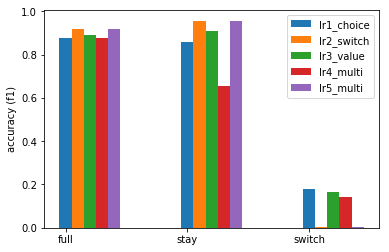

In [146]:
height_a = [score_lr1_choice, metrics_lr1_switch[2][0], metrics_lr1_switch[2][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[2][0], metrics_lr2_switch[2][1]]
height_c = [score_lr3_value_choice, metrics_lr3_switch[2][0], metrics_lr3_switch[2][1]]
height_d = [score_lr4_multi_choice, metrics_lr4_switch[2][0], metrics_lr4_switch[2][1]]
height_e = [score_lr5_multi_switch, metrics_lr5_switch[2][0], metrics_lr5_switch[2][1]]

barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
plt.bar(r3, height_c, width=barWidth, label='lr3_value')
plt.bar(r4, height_d, width=barWidth, label='lr4_multi')
plt.bar(r5, height_e, width=barWidth, label='lr5_multi')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()

## Accuracy/recall
### predicted switches/stays out of total true switches/stays

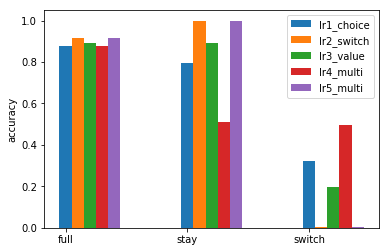

In [147]:
height_a = [score_lr1_choice, metrics_lr1_switch[1][0], metrics_lr1_switch[1][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[1][0], metrics_lr2_switch[1][1]]
height_c = [score_lr3_value_choice, metrics_lr3_switch[1][0], metrics_lr3_switch[1][1]]
height_d = [score_lr4_multi_choice, metrics_lr4_switch[1][0], metrics_lr4_switch[1][1]]
height_e = [score_lr5_multi_switch, metrics_lr5_switch[1][0], metrics_lr5_switch[1][1]]

barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
plt.bar(r3, height_c, width=barWidth, label='lr3_value')
plt.bar(r4, height_d, width=barWidth, label='lr4_multi')
plt.bar(r5, height_e, width=barWidth, label='lr5_multi')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy')
plt.legend()

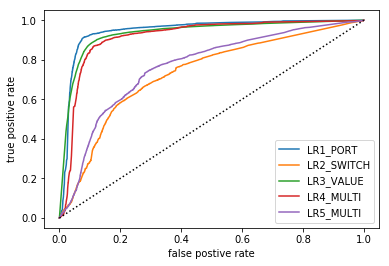

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(Y_test_choice, lr1_choice_proba[:,1])
plt.plot(fpr, tpr, label="LR1_PORT")

fpr, tpr, _ = roc_curve(Y_test_switch, lr2_switch_proba[:,1])
plt.plot(fpr, tpr, label="LR2_SWITCH")

fpr, tpr, _ = roc_curve(Y_test_choice, lr3_value_proba[:,1])
plt.plot(fpr, tpr, label="LR3_VALUE")

fpr, tpr, _ = roc_curve(Y_test_choice, lr4_multi_proba[:,1])
plt.plot(fpr, tpr, label="LR4_MULTI")

fpr, tpr, _ = roc_curve(Y_test_switch, lr5_multi_proba[:,1])
plt.plot(fpr, tpr, label="LR5_MULTI")

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

plt.legend(loc='lower right')

In [66]:
lr1_choice.coef_

array([[  1.74444720e-01,   3.12570518e-02,   1.89791913e-01,
          1.54518226e-01,   2.81410310e-01,   2.16030940e-01,
          2.77158351e-01,   4.54941815e-01,   7.03188432e-01,
          3.42204015e+00,  -3.06531398e-02,  -2.20773244e-02,
         -2.21741620e-02,  -7.26361422e-03,  -1.37672013e-03,
         -2.61835849e-02,  -3.29161408e-03,  -1.60980311e-01,
          5.09749841e-03,  -8.88580384e-03]])

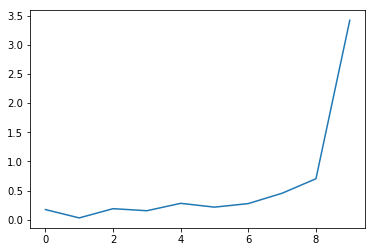

In [90]:
plt.plot(np.arange(lr1_choice.coef_.shape[1]-10),lr1_choice.coef_[0][0:10]) # to only include one type of parameters